# Male vs Female classifier based on .wav files

## Goal

The goal of this project is to get familiar with the use of sound data, working with spectrometers and to build a NN that is able to classify if the person talking in a sound sequence is a man or a woman. The idea behind this small project is to see if we could apply some of the methodology to EEG data. 

## Data

We will first use data from the OSR project (http://www.voiptroubleshooter.com/open_speech/american.html), we downloaded all the american repository to do our preliminary analysis, depending on the results we will increase the variety of speakers and introduce different accents / languages. 

## Structure 

* Exploratory data analysis (EDA) on the sound (raw and processed)
* Building multiple classifiers and compairing them
* Reproduction of https://arxiv.org/pdf/1802.08370.pdf paper
* Conclusion

## Code - EDA

### Libraries

We will start by exploring the data using librosa, this is a library that is specialized in working with audio files.
Glob will also be used to get the file names from the data directory. 

In [1]:
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob

Populating the interactive namespace from numpy and matplotlib


### Playing around with librosa

In [2]:
# Load a sample data
data, sampling_rate = librosa.load('Data/Audio/OSR_us_000_0010_8k_F.wav')

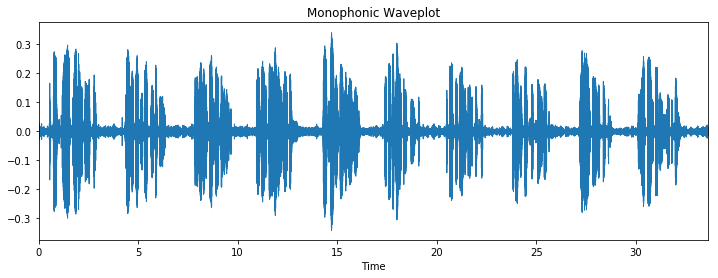

In [3]:
# Plot a monophonic waveplot
# Waveplot gives us a filled curve between [-abs(data), abs(data)]
# This can give an idea of the simple values of the .wav file 
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr = sampling_rate)
plt.title('Monophonic Waveplot')

/Users/axeluran/anaconda/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


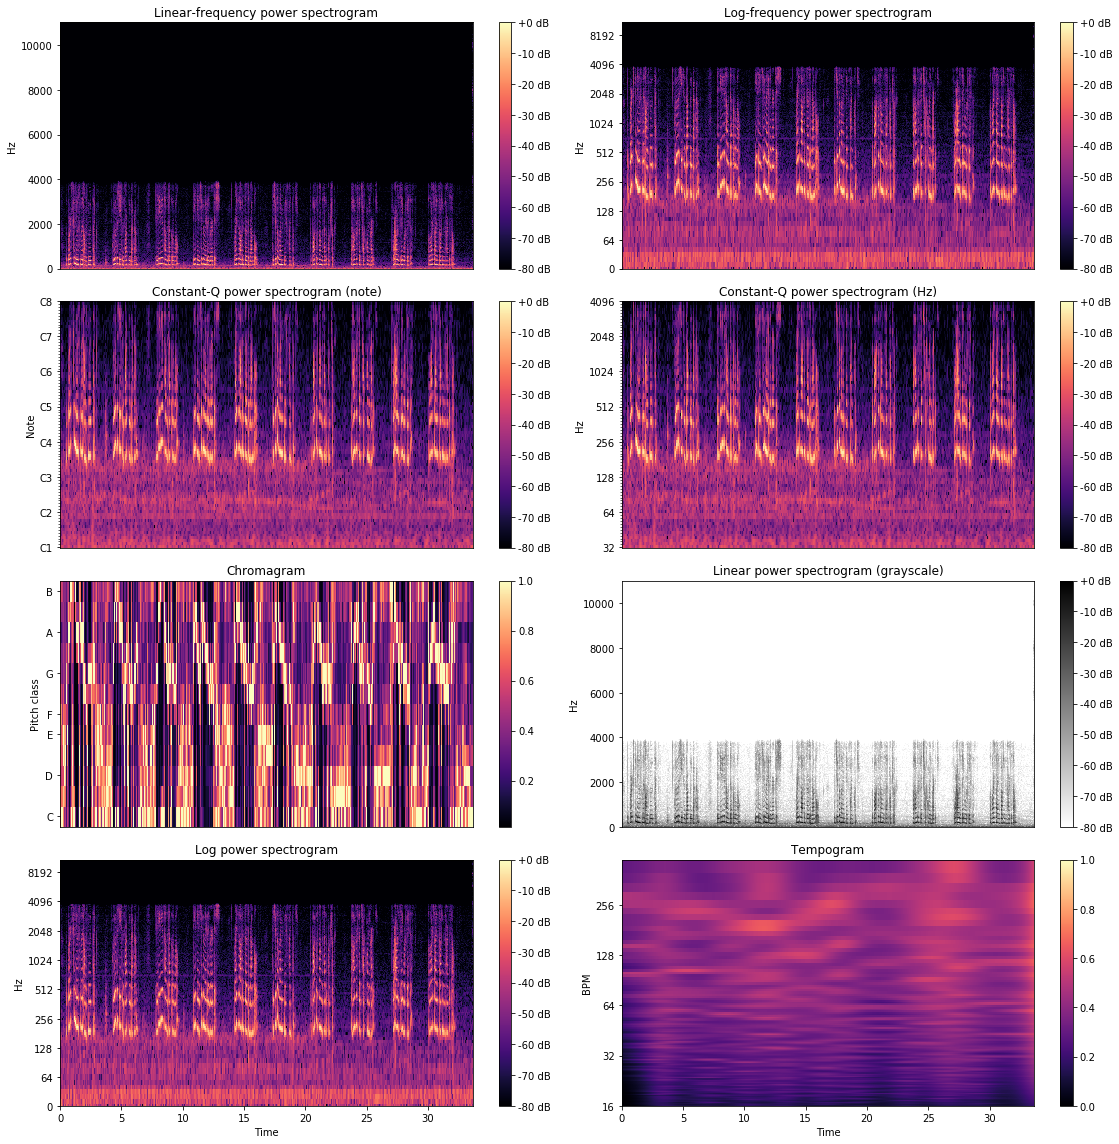

In [4]:
plt.figure(figsize=(16,16))

# In this cell we will use all the options of the librosa.display.specshow to get a feel for the library
# But in our applications we will probably only need the linear-frequency and log-frequency power spectrograms and 
# the linear and log power spectrogram 

# Linear-frequency power spectrogram 
plt.subplot(4, 2, 1)
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Log-frequency power spectrogram
plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

# Constant-Q power spectrogram (note)
CQT = librosa.amplitude_to_db(librosa.cqt(data, sr=sampling_rate), ref=np.max)
plt.subplot(4, 2, 3)
librosa.display.specshow(CQT, y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrogram (note)')

# Constant-Q power spectogram (Hz)
plt.subplot(4, 2, 4)
librosa.display.specshow(CQT, y_axis='cqt_hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrogram (Hz)')

# Chromagram 
C = librosa.feature.chroma_cqt(y=data, sr=sampling_rate)
plt.subplot(4, 2, 5)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

# Linear power spectrogram (grayscale)
plt.subplot(4, 2, 6)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear power spectrogram (grayscale)')

# Low power spectrogram
plt.subplot(4, 2, 7)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log power spectrogram')

# Tempogram
plt.subplot(4, 2, 8)
Tgram = librosa.feature.tempogram(y=data, sr=sampling_rate)
librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()

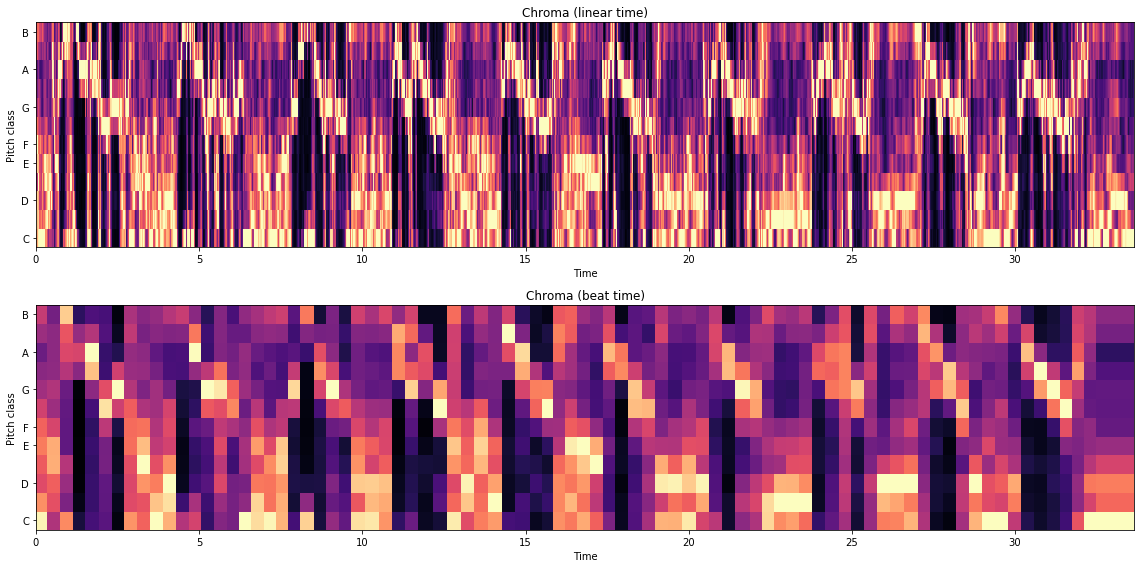

In [5]:
# In this cell we are extending the chroma functuon of specshow, but this will probably not be really usefull for 
# the classifier

plt.figure(figsize=(16,8))
tempo, beat_f = librosa.beat.beat_track(y=data, sr=sampling_rate, trim=False)
beat_f = librosa.util.fix_frames(beat_f, x_max=C.shape[1])
Csync = librosa.util.sync(C, beat_f, aggregate=np.median)
beat_t = librosa.frames_to_time(beat_f, sr=sampling_rate)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(C, y_axis='chroma', x_axis='time')
plt.title('Chroma (linear time)')
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(Csync, y_axis='chroma', x_axis='time',
                         x_coords=beat_t)
plt.title('Chroma (beat time)')
plt.tight_layout()

### Data preparation

In [16]:
files = glob.glob('Data/Audio/*.wav')
files

['Data/Audio/a0457_M.wav',
 'Data/Audio/b0434_F.wav',
 'Data/Audio/OSR_us_000_0011_8k_F.wav',
 'Data/Audio/OSR_us_000_0010_8k_F.wav',
 'Data/Audio/a0479_F.wav',
 'Data/Audio/b0073_M.wav',
 'Data/Audio/b0372_M.wav',
 'Data/Audio/a0593_M.wav',
 'Data/Audio/b0217_M.wav',
 'Data/Audio/a0204_M.wav',
 'Data/Audio/OSR_us_000_0057_8k_M.wav',
 'Data/Audio/b0370_M.wav',
 'Data/Audio/b0071_M.wav',
 'Data/Audio/a0455_M.wav',
 'Data/Audio/b0369_M.wav',
 'Data/Audio/b0436_F.wav',
 'Data/Audio/a0199_M.wav',
 'Data/Audio/a0451_M.wav',
 'Data/Audio/a0200_M.wav',
 'Data/Audio/a0173_F.wav',
 'Data/Audio/b0075_M.wav',
 'Data/Audio/b0374_M.wav',
 'Data/Audio/a0448_M.wav',
 'Data/Audio/b0007_F.wav',
 'Data/Audio/OSR_us_000_0040_8k_M.wav',
 'Data/Audio/b0077_M.wav',
 'Data/Audio/a0287_M.wav',
 'Data/Audio/b0005_F.wav',
 'Data/Audio/a0202_M.wav',
 'Data/Audio/a0171_F.wav',
 'Data/Audio/a0453_M.wav',
 'Data/Audio/OSR_us_000_0037_8k_M.wav',
 'Data/Audio/OSR_us_000_0036_8k_M.wav',
 'Data/Audio/rb-08_F.wav',
 'Da

In [17]:
features = []
labels = []

for _file in files:
    try: 
        X, sample_rate = librosa.load(str(_file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr = sample_rate, n_mfcc=40).T, axis=0)
    except Exception as e: 
        print('Error encountered while parsing file: ', _file)
    
    sex = _file[-5:-4]
    
    features.append(mfccs)
    labels.append(sex)
    
print(features)
print(labels)

[array([ -3.91549838e+02,   1.50268481e+02,  -1.41884846e+00,
         1.04360157e+01,   3.57887541e+01,   1.70193912e-02,
         8.11579726e-01,   1.71305378e+01,  -4.70858757e-02,
        -1.93198544e-01,   1.37771965e+01,   3.67108292e+00,
        -1.98298257e+00,   7.24224501e+00,   4.02979599e+00,
        -1.28066399e+00,   1.93877267e+00,   1.43891012e+00,
         1.46039479e+00,   4.19566117e+00,   1.71552282e+00,
         4.56178937e-01,   2.71044559e+00,   9.14803862e-01,
         5.54284548e-01,   2.51122998e+00,   1.14617424e+00,
         4.17137691e-01,   2.38092082e+00,   1.90628823e+00,
         1.10506277e+00,   2.20034442e+00,   8.32915170e-01,
        -3.58502717e-01,   7.45947441e-01,   1.27715261e+00,
         9.28824802e-01,   8.13875576e-01,   8.63846891e-02,
         1.77125451e-01]), array([ -4.75422068e+02,   1.87600585e+02,  -5.77682839e+01,
         2.52535087e+01,   4.51887382e+01,  -2.60538578e+01,
         1.38484537e+01,   1.89999024e+01,  -1.97083257e+

In [67]:
# Useless 
df = pd.DataFrame(
    {'features': features,
     'labels': labels,
    })

df.head()

,features,labels
0,"[-432.916723161, 135.521317439, 10.220416328, ...",F
1,"[-424.976557677, 144.359224856, 9.03815250004,...",F
2,"[-390.335563412, 140.466423312, -22.9502914926...",M
3,"[-380.094458879, 107.514532435, 0.145058729105...",M
4,"[-382.569619569, 127.403195298, -12.4525173682...",M


In [19]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X = np.array(features)
y = np.array(labels)

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

### Code - Deep learning classifier

In [20]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPool2D
from keras.optimizers import Adam
from sklearn import metrics

num_labels = y.shape[1]
filter_size = 2

# Build model
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [21]:
model.fit(X, y, batch_size=32, epochs=10)

Epoch 1/10
184/184 [==============================] - 0s - loss: 10.6951 - acc: 0.3152    
Epoch 2/10
184/184 [==============================] - 0s - loss: 10.6771 - acc: 0.3315     
Epoch 3/10
184/184 [==============================] - 0s - loss: 10.8622 - acc: 0.3261     
Epoch 4/10
184/184 [==============================] - 0s - loss: 10.9498 - acc: 0.3207     
Epoch 5/10
184/184 [==============================] - 0s - loss: 10.7746 - acc: 0.3315     
Epoch 6/10
184/184 [==============================] - 0s - loss: 10.7260 - acc: 0.3315     

### Conclusion

This model performs really badly, one of the reason might be that we don't have structured data, next step will be to try to run this model again with a better dataset and also a bigger one. 